In [1]:
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun, get_body
from astroplan import moon_illumination
from astropy.time import Time, TimeDelta
import astropy.units as u
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import imageio.v2 as imageio
import os

In [2]:
# Observation location, lat, long, elivation
BPO = [51.372840, -2.319224, 200]

# Observation Window
start_date = "2025-10-01T18:00:00"
end_date   = "2025-10-31T06:00:00"

## Finding potential variable star targets from SIMBAD

In [3]:
## SIMBAD tables, I used these to figure out how to link the tables to get the data I want in the ADQL query
#Simbad.list_columns("basic")
#Simbad.list_columns( "flux")
#Simbad.list_columns( "mesVar")

#List of varible stars from the Monson paper
#Monson_RRL_stars =["SW And", "XX And", "WY Ant", "X Ari", "ST Boo", "UY Boo", "RR Cet", "W Crt", "UY Cyg", "XZ Cyg", "DX Del", "SU Dra", "SW Dra", "RX Eri", "SV Eri", "RR Gem", "TW Her", "VX Her", "SV Hya", "V Ind", "RR Leo", "TT Lyn", "RR Lyr", "RV Oct", "UV Oct", "AV Peg", "BH Peg", "BB Pup", "HK Pup", "RU Scl", "AN Ser", "V0440 Sgr", "V0675 Sgr", "AB UMa", "RV UMa", "TU UMa", "UU Vir", "AE Boo", "TV Boo", "ST CVn", "UY Cam", "YZ Cap", "RZ Cep", "RV CrB", "CS Eri", "BX Leo", "DH Peg", "RU Psc", "SV Scl", "AP Ser", "T Sex", "MT Tel", "AM Tuc", "SX UMa", "CU Com"]

#With V* prefix to match the SIMBAD notation
Monson_RRL_stars = ["V* SW And", "V* XX And", "V* WY Ant", "V* X Ari", "V* ST Boo", "V* UY Boo", "V* RR Cet", "V* W Crt", "V* UY Cyg", "V* XZ Cyg", "V* DX Del", "V* SU Dra", "V* SW Dra", "V* RX Eri", "V* SV Eri", "V* RR Gem", "V* TW Her", "V* VX Her", "V* SV Hya", "V* V Ind", "V* RR Leo", "V* TT Lyn", "V* RR Lyr", "V* RV Oct", "V* UV Oct", "V* AV Peg", "V* BH Peg", "V* BB Pup", "V* HK Pup", "V* RU Scl", "V* AN Ser", "V* V0440 Sgr", "V* V0675 Sgr", "V* AB UMa", "V* RV UMa", "V* TU UMa", "V* UU Vir", "V* AE Boo", "V* TV Boo", "V* ST CVn", "V* UY Cam", "V* YZ Cap", "V* RZ Cep", "V* RV CrB", "V* CS Eri", "V* BX Leo", "V* DH Peg", "V* RU Psc", "V* SV Scl", "V* AP Ser", "V* T Sex", "V* MT Tel", "V* AM Tuc", "V* SX UMa", "V* CU Com"]

In [4]:
def get_variable_stars(latitude, min_alt, mag_limit):

    # Declination bounds for visibility based on observation site
    # Saves time during simbad search as not wasting time looking at stars that will never be visible
    dec_min = latitude - (90 - min_alt)
    dec_max = latitude + (90 - min_alt)
    dec_max = min(dec_max, 90.0)  # Declination can't exceed 90 degrees

    # ADQL code of getting the required info, stops repeat data and only gets stars we have a chance at seeing
    query = f"""
        SELECT basic.main_id, AVG(period) AS period, AVG(flux) AS flux, basic.ra, basic.dec
        FROM basic
        JOIN flux ON basic.oid = flux.oidref
        JOIN mesVar ON basic.oid = mesVar.oidref
        WHERE basic.otype = 'RR*' 
            AND flux <= {mag_limit}
            AND basic.dec BETWEEN {dec_min:} AND {dec_max:}
        GROUP BY basic.main_id, basic.ra, basic.dec, basic.otype
        ORDER BY main_id ASC
        """
    
    result = Simbad.query_tap(query) # Getting data for all potentially visible RR* stars

    # Converting to and cleaning up dataframe
    df = result.to_pandas()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    
    return df

In [5]:
def find_nightly_targets(df, site, start_date, end_date, dt_minutes=10.0, min_altitude=30.0, sun_night_threshold=-12.0):

    # Time grid
    tstart = Time(start_date)
    tend = Time(end_date)

    # This is here because I keep typing in the date wrong
    if tend <= tstart: raise ValueError("end_date must be after start_date")

    # Creates an array of times with intervals of df mins
    n_minutes = int(np.ceil((tend - tstart).to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Location and ref frame
    location = EarthLocation(lat=site[0]*u.deg, lon=site[1]*u.deg, height=site[2]*u.m)
    frame = AltAz(obstime=times, location=location)

    # Sun altitude and night mask
    sun_altitudes = get_sun(times).transform_to(frame).alt.deg
    is_night = sun_altitudes < sun_night_threshold

    # No night in interval, stops function
    if not np.any(is_night):
        filtered_df = df.iloc[0:0].copy()
        if return_visibility_hours:
            return filtered_df, {}
        return filtered_df
    
    # Making sure ra/dec are plain numpy arrays
    ra = np.asarray(df["ra"].values, dtype=float)
    dec = np.asarray(df["dec"].values, dtype=float)

    # Coords of the stars in ra/dec then converted to alt/az
    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
    altaz = coords[:, None].transform_to(frame) 
    altitudes = altaz.alt.deg.T    # Height in the sky

    # Apply night mask, only times at night
    night_altitudes = altitudes[is_night, :]

    # True if any time in night  time altitudes >= min altitude
    meets_alt = np.any(night_altitudes >= min_altitude, axis=0)

    # Compute hours visible for every star (even 0) so we can add to df
    dt_hours = dt_minutes / 60.0
    hours_per_star = np.sum(night_altitudes >= min_altitude, axis=0) * dt_hours

    # Attach hours to the original df
    df = df.copy()
    df["hours_visible"] = hours_per_star

    # Select rows that meet the criterion (hours > 0)
    filtered_df = df.loc[hours_per_star > 0].reset_index(drop=True)

    return filtered_df

In [6]:
# Getting candidate stars by declination/flux prefilter
candidates = get_variable_stars(BPO[0], min_alt=30.0, mag_limit=10.0)

# Filtering by visabliity
filtered_RRL = find_nightly_targets(candidates, BPO, start_date, end_date, dt_minutes=10.0, min_altitude=30.0)

# Restrict to Monson list
RRL = filtered_RRL[filtered_RRL["main_id"].isin(Monson_RRL_stars)].reset_index(drop=True)

# Print the filtered DataFrame including the hours visible, sorted by hours descending
print("Stars that appear above 30° during night in the interval (sorted by hours_visible):")
print(RRL[["main_id", "ra", "dec", "hours_visible"]].sort_values("hours_visible", ascending=False).to_string(index=False))

Stars that appear above 30° during night in the interval (sorted by hours_visible):
  main_id         ra       dec  hours_visible
V* SW Dra 184.444285 69.510620     328.000000
V* RZ Cep 339.804904 64.858503     327.833333
V* XX And  19.364226 38.950569     321.666667
V* SW And   5.929540 29.401007     288.166667
V* RU Psc  18.608488 24.415658     285.833333
V* SU Dra 174.485863 67.329739     229.833333
V* XZ Cyg 293.122105 56.388193     218.833333
V* BH Peg 343.254321 15.787947     210.666667
 V* X Ari  47.128686 10.445894     208.500000
V* AV Peg 328.011644 22.574827     196.666667
V* UY Cyg 314.117929 30.427869     187.000000
V* RR Lyr 291.366304 42.784359     171.333333
V* DH Peg 333.856832  6.822622     167.000000
V* RR Cet  23.034055  1.341731     158.500000
V* DX Del 311.868148 12.464078     139.166667
V* TT Lyn 135.782444 44.585589     127.333333
V* RV UMa 203.325350 53.987388      54.166667
V* RR Leo 151.931086 23.991755      45.833333
V* AB UMa 182.810788 47.828832      42.833

## Plotting star paths

In [49]:
def plot_star_path(df, names, site, start_date, end_date, dt_minutes=10.0, min_altitude=30.0):
    
    # Select stars
    plot_stars = df[df["main_id"].isin(names)]
    if plot_stars.empty: raise ValueError("No matching stars found in data frame")

    # Build time array from start_date to end_date with steps of dt_minutes
    tstart = Time(start_date)
    tend = Time(end_date)
    if tend <= tstart: raise ValueError("end_date must be after start_date")

    n_minutes = int(np.ceil((tend - tstart).to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Observer frame
    location = EarthLocation(lat=site[0]*u.deg, lon=site[1]*u.deg, height=site[2]*u.m)
    frame = AltAz(obstime=times, location=location)

    # Sun altitudes for shading
    sun_altitudes = get_sun(times).transform_to(frame).alt.deg

    plt.figure(figsize=(12,6))
    ax = plt.gca()

    # Colours depending on sunlight
    sky_shade = {"daylight": "#ffffcc", "civil": "#ffe6cc", "nautical": "#e6f2ff", "astronomical": "#e6e6ff", "night": "#d9d9d9"}

    # Shade background by sun altitude bands
    for i in range(len(times) - 1):
        alt = sun_altitudes[i]
        t0 = times[i].plot_date
        t1 = times[i+1].plot_date

        if alt > 0: shade = sky_shade["daylight"]
        elif alt > -6: shade = sky_shade["civil"]
        elif alt > -12: shade = sky_shade["nautical"]
        elif alt > -18: shade = sky_shade["astronomical"]
        else: shade = sky_shade["night"]

        ax.axvspan(t0, t1, color=shade)    #setting that section of the graph to the corresponding colour

    # Compute alt/az for all selected stars at once
    ra = np.asarray(plot_stars["ra"].values, dtype=float)
    dec = np.asarray(plot_stars["dec"].values, dtype=float)
    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
    
    # transform to alt/az coord system
    altaz = coords[:, None].transform_to(frame)
    altitudes = altaz.alt.deg.T

    # Plot each star's altitude track
    for col_idx, name in enumerate(plot_stars["main_id"].values):
        plt.plot(times.plot_date, altitudes[:, col_idx], label=name)

    # Minimum altitude line
    plt.axhline(min_altitude, color="k", linestyle="--", linewidth=0.8, label=f"min alt {min_altitude} deg")

    # Formatting
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d-%m-%Y\n%H:%M"))
    plt.ylabel("Altitude (deg)")
    plt.xlabel("Time")
    plt.ylim(0, 95)
    plt.legend(loc="best", fontsize="small", ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

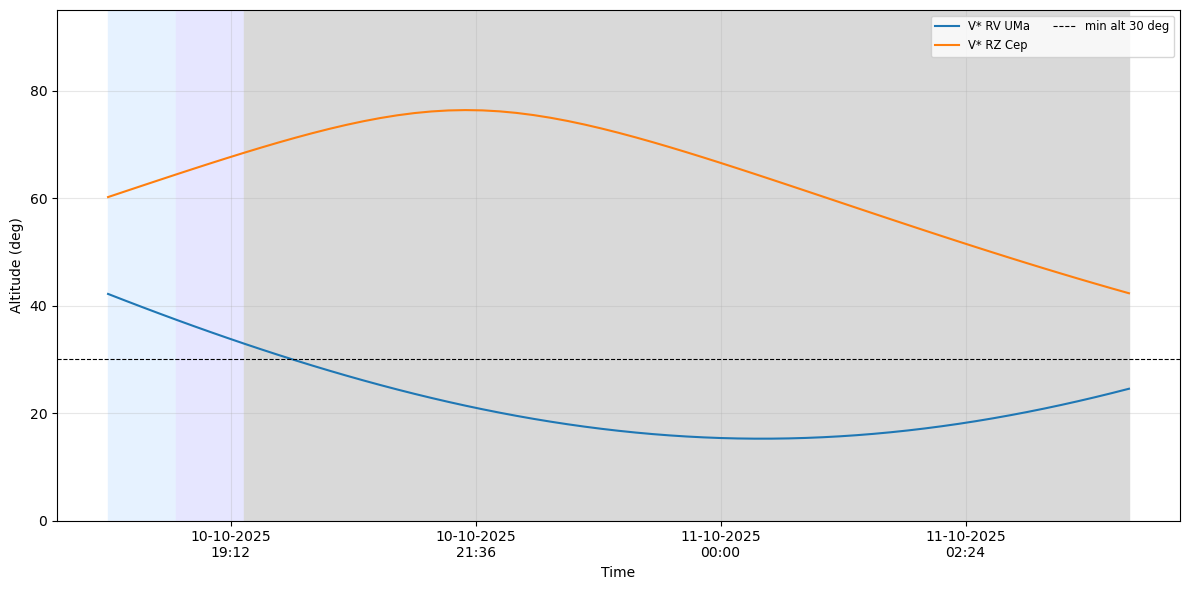

In [50]:
plot_stars = ["V* RV UMa", "V* RZ Cep"]         # Previous years
#plot_stars = RRL['main_id'].to_list()    # Stars found through SIMBAD

# Plot star paths during a window
plot_star_path(RRL, plot_stars, BPO, start_date="2025-10-10T18:00:00", end_date="2025-10-11T06:00:00", dt_minutes=10, min_altitude=30)

## Finding closest standard stars

In [9]:
# Reading in a file containing info about landolt standard stars in the northen hemisphere
All_SS = pd.read_csv("data/landolt_north.csv",delimiter = "|")
All_SS.columns = ['oid', 'main_id', 'ra', 'dec']

# Filter using the same method as the RRl stars
SS = find_nightly_targets(All_SS, BPO, start_date, end_date, dt_minutes=10.0, min_altitude=30.0)

In [10]:
def match_to_standards(vars_df, stds_df, vars_ra_col="ra", vars_dec_col="dec", stds_ra_col="ra", stds_dec_col="dec", std_name_col="main_id"):
    
    # Ensure numeric arrays
    vars_ra = np.asarray(vars_df[vars_ra_col].values, dtype=float)
    vars_dec = np.asarray(vars_df[vars_dec_col].values, dtype=float)
    stds_ra = np.asarray(stds_df[stds_ra_col].values, dtype=float)
    stds_dec = np.asarray(stds_df[stds_dec_col].values, dtype=float)

    # Build SkyCoord objects
    coords_vars = SkyCoord(ra=vars_ra * u.deg, dec=vars_dec * u.deg)
    coords_stds = SkyCoord(ra=stds_ra * u.deg, dec=stds_dec * u.deg)

    # Match each variable to the nearest standard star
    idx, sep2d, _ = coords_vars.match_to_catalog_sky(coords_stds)

    # Build result DataFrame
    result = vars_df.copy().reset_index(drop=True)
    result["matched_standard"] = stds_df.iloc[idx][std_name_col].values
    result["standard_ra"] = stds_df.iloc[idx][stds_ra_col].values
    result["standard_dec"] = stds_df.iloc[idx][stds_dec_col].values
    result["sep_arcsec"] = sep2d.arcsec

    return result

In [11]:
# Find nearest standard for every RRL
matched_df = match_to_standards(RRL, SS)

# Show all results
print(matched_df.sort_values("sep_arcsec").to_string(index=False))

  main_id   period     flux         ra       dec  hours_visible      matched_standard  standard_ra  standard_dec    sep_arcsec
V* XX And 0.722608 9.475000  19.364226 38.950569     321.666667 UCAC4 648-004238         16.772410     39.524546   7516.062506
V* RV UMa 0.468049 9.827000 203.325350 53.987388      54.166667 PG 1343+578             206.255895     57.503557  13978.742300
V* SW And 0.442283 9.066586   5.929540 29.401007     288.166667 UCAC4 608-001920          9.920698     31.545703  14591.403452
V* TT Lyn 0.552655 9.275844 135.782444 44.585589     127.333333 UCAC4 652-048948        134.290790     40.309770  15893.956472
V* AB UMa 0.599582 9.714000 182.810788 47.828832      42.833333 UCAC4 716-051194        183.351807     53.040889  18804.219748
V* RR Lyr 0.498414 7.144801 291.366304 42.784359     171.333333 UCAC4 676-066011        282.692321     45.098044  23962.644127
V* SU Dra 0.660340 9.257904 174.485863 67.329739     229.833333 UCAC4 754-046742        181.006663     60.63015

## Moon!

In [12]:
def plot_moon_illumination(start_date, end_date, dt_minutes=10.0):
    tstart = Time(start_date)
    tend = Time(end_date)
    n_minutes = int(np.ceil((tend - tstart).to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Moon illumination at each time
    illumination = moon_illumination(times)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(times.datetime, illumination * 100, color="k")
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d-%m-%Y\n%H:%M"))
    plt.ylabel("Moon Illumination (%)")
    plt.xlabel("Date and Time")
    plt.title("Moon Illumination Over Time")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

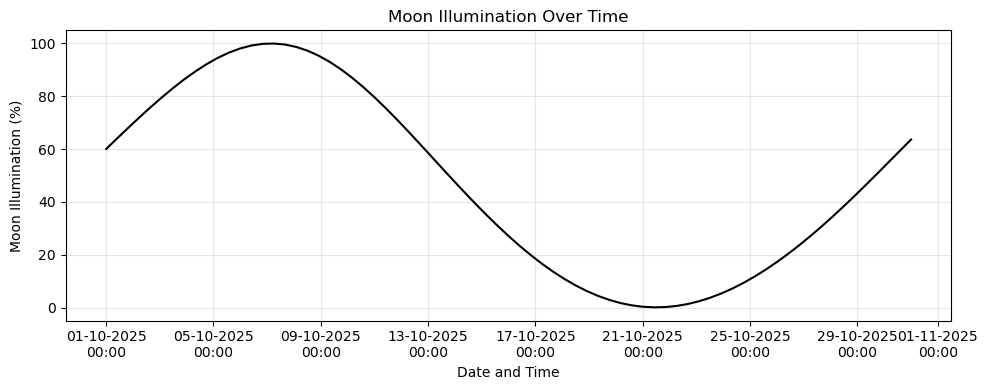

In [13]:
start_date = "2025-10-01T00:00:00"
end_date   = "2025-10-31T00:00:00"

plot_moon_illumination(start_date, end_date, dt_minutes=600)

## All together

In [51]:
def plot_night(star_name, matched_df, site, tstart, duration, dt_minutes=15.0, min_altitude=30.0, show=True, save=False):
    
    # Find the row for the requested star
    row = matched_df[matched_df["main_id"] == star_name]

    # Extract star info
    var_ra = row.iloc[0]["ra"]
    var_dec = row.iloc[0]["dec"]
    var_name = row.iloc[0]["main_id"]
    std_ra = row.iloc[0]["standard_ra"]
    std_dec = row.iloc[0]["standard_dec"]
    std_name = row.iloc[0]["matched_standard"]

    # Time grid
    tend = tstart + duration
    n_minutes = int(np.ceil(duration.to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Observer location and frame
    location = EarthLocation(lat=site[0]*u.deg, lon=site[1]*u.deg, height=site[2]*u.m)
    frame = AltAz(obstime=times, location=location)

    # SkyCoords
    var_coord = SkyCoord(ra=var_ra*u.deg, dec=var_dec*u.deg)
    std_coord = SkyCoord(ra=std_ra*u.deg, dec=std_dec*u.deg)

    # Moon SkyCoords and illumination
    moon_coord = get_body("moon", times, location).transform_to(frame)
    moon_illum = moon_illumination(times)

    # To AltAz
    var_altaz = var_coord.transform_to(frame)
    std_altaz = std_coord.transform_to(frame)

    # Filter for altitudes above horizon
    mask_var = var_altaz.alt > 0*u.deg
    mask_std = std_altaz.alt > 0*u.deg
    mask_moon = moon_coord.alt > 0*u.deg

    # Convert to polar coordinates
    az_var = var_altaz.az[mask_var].rad
    r_var = var_altaz.alt[mask_var].deg
    az_std = std_altaz.az[mask_std].rad
    r_std = std_altaz.alt[mask_std].deg
    az_moon = moon_coord.az[mask_moon].rad
    r_moon = moon_coord.alt[mask_moon].deg
    illum_moon = moon_illum[mask_moon]

    # Create polar plot
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(90, 0)  # Zenith at center, horizon at edge
    ax.grid(True, alpha=0.2)

    # ALt/Az label
    alt_ticks = np.arange(0, 100, 15)  # 0 to 90
    alt_labels = [f"{alt}°" for alt in alt_ticks]
    ax.set_rgrids(alt_ticks, labels=alt_labels, angle=20)
    ax.text(np.deg2rad(20), -10, "Altitude (deg)", ha="left", va="center", fontsize=10)
    ax.text(0, -8, "Azimuth (deg)", ha="center", va="bottom", fontsize=10)

    # Compass labels
    compass_labels = {"N": 0, "E": 90, "S": 180, "W": 270}
    for label, deg in compass_labels.items():
        angle_rad = np.deg2rad(deg)
        ax.text(angle_rad, -15, label, ha="center", va="center", fontsize=10, fontweight="bold")

    # Add date label to top-right corner of the plot
    date_str = "Night of observation: " + (tstart.datetime.strftime("%d.%m.%Y"))
    fig.text(0.05, 0.95, date_str, fontsize=10)

    # Shade region below minimum altitude
    ax.plot(np.linspace(0, 2*np.pi, 360), [min_altitude]*360, color="gray", linestyle="--", linewidth=1)
    theta = np.linspace(0, 2*np.pi, 500)
    ax.fill_between(theta, min_altitude, 0, color="lightgray", alpha=0.4)

    # Plot paths
    ax.plot(az_var, r_var, color="blue", linewidth=2)
    ax.plot(az_std, r_std, color="green", linestyle="--")

    # Label star names
    if len(r_var) > 0:
        i_var_peak = np.argmax(r_var)
        ax.text(az_var[i_var_peak]+6, r_var[i_var_peak], var_name, color="blue", fontsize=9)
    if len(r_std) > 0:
        i_std_peak = np.argmax(r_std)
        ax.text(az_std[i_std_peak], r_std[i_std_peak]+5, std_name, color="green", fontsize=9)

    # Moon path with illumination shading
    moon_colors = plt.cm.Greys(illum_moon)
    ax.scatter(az_moon, r_moon, c=moon_colors, s=30)

    # Label moon illumination
    if len(r_moon) > 0:
        i_peak = np.argmax(r_moon)  # highest altitude
        illum_pct = int(illum_moon[i_peak] * 100)
        ax.text(az_moon[i_peak], r_moon[i_peak] - 10, f"Moon\n{illum_pct}%", fontsize=9)

    # Save and/or showing
    if save:
        fixed_name = star_name.replace(" ", "_")[3:]
        start_str = tstart.datetime.strftime("%Y-%m-%d_%H-%M")
        end_str = tend.datetime.strftime("%Y-%m-%d_%H-%M")
        filename = f"{fixed_name}_{start_str}_to_{end_str}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")

    if show: plt.show()
    else: plt.close()


In [52]:
def animate(star_name, start_night, nights, duration, output_folder="."):

    fixed_name = star_name.replace(" ", "_")[3:]     # Removes white space and V* start so can save as a file
    frames = []

    # Finding the saved images of the star and dates requested
    for night in range(nights):
        obs_start = start_night + TimeDelta(night, format="jd")
        obs_end = obs_start + duration
        start_str = obs_start.datetime.strftime("%Y-%m-%d_%H-%M")
        end_str = obs_end.datetime.strftime("%Y-%m-%d_%H-%M")
        filename = os.path.join(output_folder, f"{fixed_name}_{start_str}_to_{end_str}.png")
        if os.path.exists(filename):
            frames.append(imageio.imread(filename))
        else:
            print(f"Missing frame: {filename}")

    if not frames:
        print("No frames found — animation not created.")
        return
        
    # Create and save animation
    gif_name = f"{fixed_name}_animation.gif"
    gif_path = os.path.join(output_folder, gif_name)
    imageio.mimsave(gif_path, frames, duration=0.5)

In [55]:
obs_start = Time("2025-10-10T20:00:00")
duration = TimeDelta(10 * 3600, format="sec") # 10 hours in seconds

plot_stars = ["V* RV UMa", "V* RZ Cep"]
#plot_stars = matched_df["main_id"]

for VStar in plot_stars:
    plot_night(VStar, matched_df, BPO, obs_start, duration, min_altitude=30, show=True, save=False)

#For one star across a time period
VStar = "V* RZ Cep"
nights = 30
for night in range(nights):
    obs_start = start_night + TimeDelta(night, format="jd")
    plot_night(VStar, matched_df, BPO, obs_start, duration, min_altitude=30, show=False, save=True)

animate(VStar, start_night, nights, duration)
